# RegVelo-based analyis of zebrafish data

Notebook runs RegVelo on zebrafish dataset.

## Library imports

In [1]:
import numpy as np
import pandas as pd
import scipy
import torch

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import cellrank as cr
import scanpy as sc
import scvi
from regvelo import REGVELOVI

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.benchmarking import set_output

/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packag

## General settings

In [2]:
scvi.settings.seed = 0

[rank: 0] Seed set to 0


## Constants

In [3]:
DATASET = "zebrafish"

In [4]:
SAVE_DATA = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "processed").mkdir(parents=True, exist_ok=True)

In [5]:
SAVE_FIGURES = False
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

In [6]:
TERMINAL_STATES = [
    "mNC_head_mesenchymal",
    "mNC_arch2",
    "mNC_hox34",
    "Pigment",
]

## Function definitions

In [7]:
def min_max_scaling(data):
    """Compute min and max values for each feature."""
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)

    # Perform min-max scaling
    scaled_data = (data - min_vals) / (max_vals - min_vals)

    return scaled_data

## Data loading

In [8]:
adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_preprocessed.h5ad")

## Velocity pipeline

In [9]:
# Prepare skeleton
W = adata.uns["skeleton"].copy()
W = torch.tensor(np.array(W)).int()

# Prepare TF
TF = adata.var_names[adata.var["TF"]]

# Prepare model
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = REGVELOVI(adata, W=W.T, regulators=TF, soft_constraint=False)

In [10]:
vae.train()

/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/dynamo/lib/pyth ...
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/dynamo/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on yo

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2350.604. Signaling Trainer to stop.


In [11]:
set_output(adata, vae, n_samples=30, batch_size=adata.n_obs)

## Latent time analysis

In [12]:
adata.obs["latent_time"] = min_max_scaling(adata.layers["fit_t"].mean(axis=1))

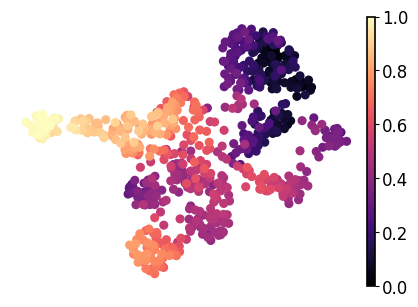

In [13]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(5, 3.5))
    sc.pl.umap(adata=adata, color="latent_time", title="", frameon=False, legend_fontsize=14, cmap="magma", ax=ax)

    if SAVE_FIGURES:
        fig.savefig(FIG_DIR / DATASET / "latent_time.svg", format="svg", transparent=True, bbox_inches="tight")

In [14]:
df = pd.DataFrame({"stage": adata.obs["stage"].tolist(), "latent_time": adata.obs["latent_time"].tolist()})

In [15]:
adata.obs["stage_num"] = 0
adata.obs["stage_num"][adata.obs["stage"].isin(["3ss"])] = 3
adata.obs["stage_num"][adata.obs["stage"].isin(["6-7ss"])] = 6.5
adata.obs["stage_num"][adata.obs["stage"].isin(["10ss"])] = 10
adata.obs["stage_num"][adata.obs["stage"].isin(["12-13ss"])] = 12.5
adata.obs["stage_num"][adata.obs["stage"].isin(["17-18ss"])] = 17.5
adata.obs["stage_num"][adata.obs["stage"].isin(["21-22ss"])] = 21.5

In [16]:
scipy.stats.spearmanr(adata.obs["stage_num"].tolist(), adata.obs["latent_time"].tolist())

SignificanceResult(statistic=0.7986219557089823, pvalue=2.0602518323614564e-155)

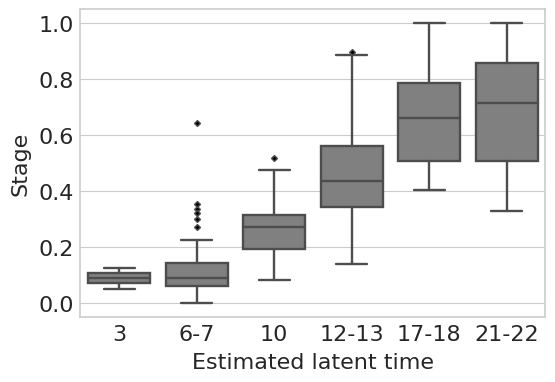

In [17]:
loc = [0, 1, 2, 3, 4, 5]
label = ["3", "6-7", "10", "12-13", "17-18", "21-22"]

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))
    order = ["3ss", "6-7ss", "10ss", "12-13ss", "17-18ss", "21-22ss"]
    flierprops = {"marker": "D", "markerfacecolor": "black", "markersize": 3, "linestyle": "none"}
    sns.boxplot(data=df, x="stage", y="latent_time", order=order, color="grey", ax=ax, flierprops=flierprops)
    # Set labels and title
    plt.ylabel("Stage", fontsize=16)
    plt.xlabel("Estimated latent time", fontsize=16)

    plt.xticks(ticks=loc, labels=label)  # Replace ticks with new labels
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.show()

    if SAVE_FIGURES:
        fig.savefig(FIG_DIR / DATASET / "latent_time_boxplot.svg", format="svg", transparent=True, bbox_inches="tight")
    plt.show()

## CellRank pipeline

In [18]:
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()

kernel = 0.8 * vk + 0.2 * ck

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

In [19]:
estimator = cr.estimators.GPCCA(kernel)
estimator.compute_macrostates(n_states=8, n_cells=30, cluster_key="cell_type")
estimator.set_terminal_states(TERMINAL_STATES)

GPCCA[kernel=(0.8 * VelocityKernel[n=697] + 0.2 * ConnectivityKernel[n=697]), initial_states=None, terminal_states=['Pigment', 'mNC_arch2', 'mNC_head_mesenchymal', 'mNC_hox34']]

/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/scvelo/plotting/utils.py:1391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/scvelo/plotting/utils.py:1392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


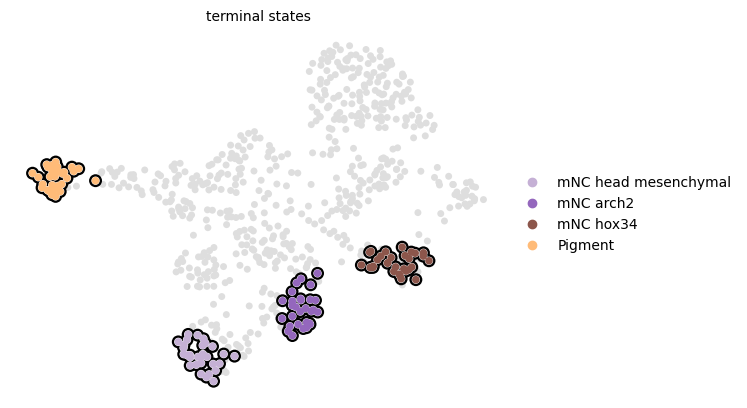

In [20]:
estimator.plot_macrostates(which="terminal", basis="umap", legend_loc="right", s=100)

## Save dataset

In [21]:
if SAVE_DATA:
    adata.write_h5ad(DATA_DIR / DATASET / "processed" / "adata_run_regvelo.h5ad")
    vae.save(DATA_DIR / DATASET / "processed" / "rgv_model")